In [1]:
from funcs.notebook import *
from funcs.transitmask import get_full_transit_mask, fit_and_remove_transits
from funcs.detrend import custom_detrending, estimate_detrended_noise
import time

import transitleastsquares as tls

sep = "-----------------------------------------"

def mprint(message):
    print(sep)
    print(message)
    print(sep)
    
offset = {"K2":2454833.,"Kepler":2454833.,"TESS":2457000., 
          "Transiting Exoplanet Survey Satellite (TESS)" : 2457000.}    


from altaipony.lcio import from_mast
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median

In [2]:
# Composite Table of confirmed exoplanets
path = "20_01_2021_confirmed_uncontroversial_exoplanet_systems.csv"

mprint(f"[UP] Using confirmed and uncontroversial "
      "entries in NASA Composite Table from {path}")

exokepler = pd.read_csv(f"../data/{path}") # composite table

# read in TESS-TOI sample 
path = "../data/2021_01_13_TESS_TOI_CATALOG.csv"

mprint(f"[UP] Using TESS-TOI Table from {path}")

exotess = pd.read_csv(path, skiprows=4)

# rename the relevant columns for transit masking
exotess = exotess.rename(index=str, 
                         columns={'Transit Duration Value':"pl_trandur",
                                  'Orbital Period Value': "pl_orbper",
                                  'Orbital Period Error': "pl_orbpererr",
                                  'Epoch Value':"pl_tranmidepoch",
                                  'Epoch Error':"pl_tranmidepocherr"})


# read in list of LCs to search
es = pd.read_csv("../data/20_01_2021_full_kepler_k2_tess_exoplanet_lcs_some_excluded.csv")

# select only Kepler and TESS, ignore K2 for now
eskeptess = es[(es.mission=="TESS") | (es.mission=="Kepler")]

# read in searched LCs with and without flares
flares = pd.read_csv("../results/2020_02_flares_vetted.csv")
fla = flares[(flares["real?"]==1)]

# pick only LC that were not yet searched
#eskeptess = eskeptess[~eskeptess.ID.isin(fla.ID.unique())]

-----------------------------------------
[UP] Using confirmed and uncontroversial entries in NASA Composite Table from {path}
-----------------------------------------


NumExpr defaulting to 8 threads.


-----------------------------------------
[UP] Using TESS-TOI Table from ../data/2021_01_13_TESS_TOI_CATALOG.csv
-----------------------------------------


In [ ]:
exokepler.columns.values

In [ ]:
flares.groupby(["ID", "qcs"]).count().shape, eskeptess.groupby(["ID", "qcs", "mission"]).count().shape

In [ ]:
ff = fla[["ID", "qcs"]].drop_duplicates(keep="first")

In [ ]:
obsdurs = pd.read_csv("../results/2020_02_obsdurs.csv")
missing = pd.concat([obsdurs, ff]).drop_duplicates(subset=["ID", "qcs"], 
                                                          keep=False)
obsdurs.shape, missing.shape

In [ ]:
a = set(ff.ID.unique())
b = set(obsdurs.ID.unique())
left =  list(a - b)

In [ ]:
len(a), len(b), len(left)

In [ ]:
TSTART = time.time()
n=0
N = ff.shape[0]


for ID in left:
    
    rows = eskeptess[(ID == eskeptess["ID"])]
    
    available_lcs = rows.shape[0]
    for j, row in rows.iterrows():
        # TIC is unique ID for star
        system_tess = exotess[(exotess.TIC == row.TIC)]


        # ID is unique, also ignore entries that have no transits
        # because there is nothing to mask (they are still searched for flares)
        system_kepler = exokepler[(exokepler.hostname == row.ID) &
                           (exokepler.discoverymethod == "Transit")]
        
        system_kepler["pl_orbpererr"] = (system_kepler.pl_orbpererr1 +
                                         system_kepler.pl_orbpererr2) / 2

        try:
            if system_kepler.shape[0] > 0:
                system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                    offset[system_kepler.iloc[0].disc_facility])
                system_kepler["pl_tranmidepocherr"] = (system_kepler.pl_tranmiderr1 +
                                                  system_kepler.pl_tranmiderr2) / 2
            system = pd.concat([system_kepler, system_tess],ignore_index=True)

        except KeyError:
            system = system_tess
            print(system_kepler.pl_tranmid_systemref)

        # fetch light curve from MAST
        flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                        download_dir="/home/ekaterina/Documents/001_science/lcs")

        # make it a list of LCs even if only one LC is returned
        if type(flc) == FlareLightCurve:

            flc = [flc]

        elif type(flc) == list:

            flc = flc

        # info
        mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")
        
        if row.mission == "TESS":
            flc = flc[:1]

        # loop over all LCs for the system    
        for i, f in enumerate(flc):

            # If any planet transiting
            if system.shape[0] > 0:

                # mask transits
                tranmask = get_full_transit_mask(system, f, pad=0)
                f.flux[tranmask] = np.nan

            # get timestamp for result
            tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
            # apply custom detrending
            
            try:
                ts = time.clock()
                fd = custom_detrending(f)
                tf = time.clock()


                # define two hour window for rolling std
                w = np.floor(1. / 12. / np.nanmin(np.diff(fd.time)))
                if w%2==0: 
                    w+=1

                # use window to estimate the noise in the LC
                df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=1.5)

                fin = np.isfinite(df.detrended_flux)

                        # add results to file
                with open("../results/2020_02_obsdurs.csv", "a") as file:
                    s = f"{row.ID},{row.qcs},{i},{df.detrended_flux[fin].shape[0]},{row.mission},{available_lcs}\n"
                    file.write(s)    # info

                with open(f"../results/observedtimes/{row.ID}_{row.qcs}_{i}_{row.mission}.csv", "w") as file:
                    d = pd.DataFrame({"time":df.time[fin],"flux":df.detrended_flux[fin]})
                    d.to_csv(file,index=False)
            except Exception as err:
                with open("../results/nodetrend_phase.txt", "a") as file:
                    s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
                    file.write(s)
        n += 1
        print(f"{n / N * 100.:.1f}%, [{n}/{N}]")

        # breathe
        time.sleep(10)

TSTOP = time.time()
mprint(f"Analysis of {N} light curves took {(TSTOP - TSTART) / 60. / 60.:.1f} hours.")

# Add one

In [127]:
ID = "Kepler-16"
rows = eskeptess[(ID == eskeptess["ID"])]
available_lcs = rows.shape[0]

In [130]:
row = eskeptess[(ID == eskeptess["ID"])].iloc[8]
print(row.qcs)

17


In [131]:
%matplotlib inline
# TIC is unique ID for star
system_tess = exotess[(exotess.TIC == row.TIC)]

# ID is unique, also ignore entries that have no transits
# because there is nothing to mask (they are still searched for flares)
system_kepler = exokepler[(exokepler.hostname == row.ID) &
                   (exokepler.discoverymethod == "Transit")]

try:
    if system_kepler.shape[0] > 0:
        system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                            offset[system_kepler.iloc[0].disc_facility])
    system = pd.concat([system_kepler, system_tess],ignore_index=True)

except KeyError:
    system = system_tess
    print(system.columns)

    
system.T

/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,0
hostname,Kepler-16
rowid,2262
pl_name,Kepler-16 b
pl_letter,b
hd_name,NaN
...,...
TFOP SG3,NaN
TFOP SG4,NaN
TFOP SG5,NaN
Alerted,NaN


In [132]:
# fetch light curve from MAST
flc = from_mast(row.ID, mission=row.mission, c=row.qcs, cadence="short",
                download_dir="/home/ekaterina/Documents/001_science/lcs")

# from astropy.io import fits
# hdu = fits.open("/home/ekaterina/Documents/001_science/lcs/mastDownload/TESS/tess2018349182459-s0006-0000000032090583-0126-s_lc.fits")
# t = hdu[1].data['TIME']
# flu = hdu[1].data['PDCSAP_FLUX'].astype(np.float64) # values with non-zero quality are nan or zero'ed
# # make it a list of LCs even if only one LC is returned
# mask = np.where(np.isfinite(t))

/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/lightkurve/io/kepler.py:38: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/Kepler/kplr012644769_sc_Q001000000033333322/kplr012644769-2013121191144_slc.fits' mode='rb' closefd=True>
  time_format="bkjd",
1% (248/32850) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
1% (248/32850) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/lightkurve/io/kepler.py:38: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_science/lcs/mastDownload/Kepler/kplr012644769_sc_Q001000000033333322/kplr012644769-2013131215648_slc.fits' mode='rb' closefd=True>
  time_format="bkjd",
0% (28/6180) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (28/6180) of the cadences will be ignored

In [133]:
flc

[FlareLightCurve(ID: 12644769), FlareLightCurve(ID: 12644769)]

In [134]:
# flc = FlareLightCurve(time=t[mask], flux=flu[mask])

if type(flc) == FlareLightCurve:

    flc = [flc]

elif type(flc) == list:

    flc = flc

# info
mprint(f"{len(flc)} light curves available for {row.ID} in {row.mission}.")

if row.mission == "TESS":
    flc = flc[:1]

-----------------------------------------
2 light curves available for Kepler-16 in Kepler.
-----------------------------------------


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

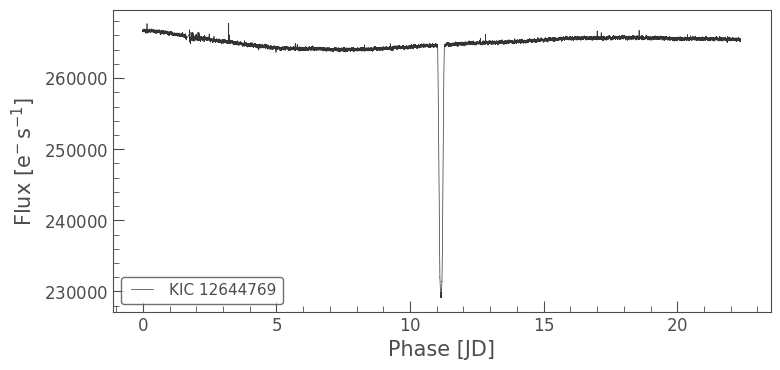

In [135]:
flc[0].fold(system.pl_orbper.iloc[0]).plot()


/home/ekaterina/Documents/001_science/Flaring_SPI/notebooks/funcs/detrend.py:237: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * (c - x)) + d * np.exp(e * (f - x)) + g
/home/ekaterina/Documents/001_science/Flaring_SPI/notebooks/funcs/detrend.py:237: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(b * (c - x)) + d * np.exp(e * (f - x)) + g


0.028097976000026392 0.003124093999986144 2.0401018790000194 2.0443986459999905 1.937158291000003 2.0737648229999763 8.126645709000002
[1559.2172063  1559.21788741 1559.21856852 ... 1581.39228035 1581.39296147
 1581.39364268]
1581.3936426848086 1559.2172062953105 228.77599999999998
No transit duration uncertainty given.
[1559.2172063  1559.21790074 1559.21859519 ... 1581.39225379 1581.39294824
 1581.39364268] [1.00469168 1.00424411 1.00394139 ... 0.99993258 0.99953623 1.00002701] (31935,) (31935,)
171.582 343.164 0 0.08 1.3 0.13 1.3 0
Transit Least Squares TLS 1.0.28 (13 June 2021)
Creating model cache for 37 durations
Searching 31935 data points, 1944 periods from 0.602 to 11.088 days
Using all 8 CPU threads


100%|██████████████████████████████████████████| 1944/1944 periods | 00:24<00:00
/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/transitleastsquares/helpers.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = idx.astype(numpy.int)  # needed if oversampling_factor is not int


Searching for best T0 for period 11.08822 days


100%|█████████████████████████████████████| 5622/5622 [00:02<00:00, 2350.12it/s]
/home/ekaterina/Documents/000_envs/python37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


FIN


Found 1 candidate(s) in the (0,2385) gap.
Found 1 candidate(s) in the (2385,32310) gap.


FIN2


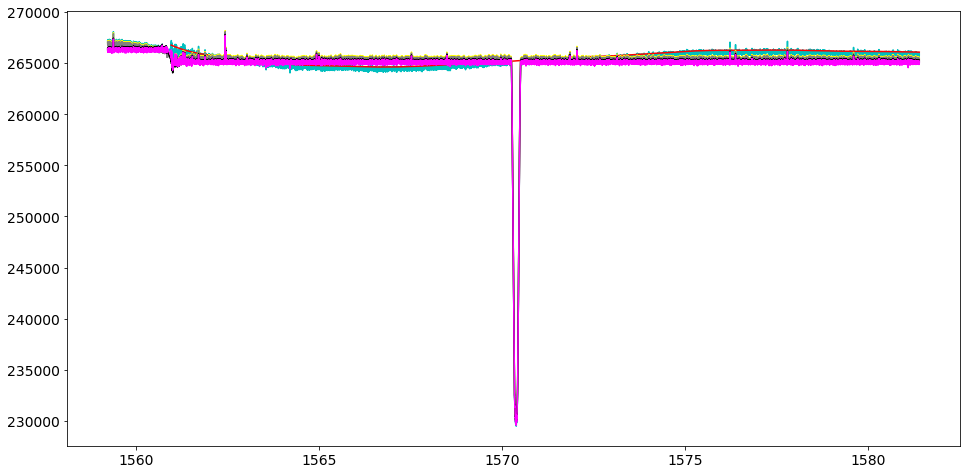

In [144]:
# loop over all LCs for the system    
for i, f in enumerate(flc):
    if i !=0:
        continue

    # get timestamp for result
    tstamp = time.strftime("%d_%m_%Y_%H_%M_%S", time.localtime())
    # apply custom detrending

#     try:
    ts = time.process_time()
#     f.flux[-2:] = np.nan
    fd = custom_detrending(f)

    # Fit the transits
    # If any planet transiting
    periods = []
    if system.shape[0] > 0:
        for j,r in system.iterrows():

            timearr, flux = tls.cleaned_array(fd.time.value, fd.detrended_flux.value)
            print(timearr)
            notransit_flux, results = fit_and_remove_transits(timearr, flux,
                                                             pl_orbper=r.pl_orbper,)
            fd.detrended_flux = notransit_flux
            periods.append(results.period)

        # add periods to file
        pers = pd.DataFrame({"ID":row.ID,
                             "qcs":row.qcs,
                             "lc_n":i,
                             "mission":row.mission,
                             "orbper_tls" : results.period,
                             "pl_tranmidepoch_tls" : results.T0,
                             "orbper_nasa" : system.pl_orbper,
                             "orbper_err_nasa" : system.pl_orbpererr,
                             "pl_tranmidepoch_nasa" : system.pl_tranmidepoch,
                             })
        with open("../results/2021_08_orbpers.csv", "a") as file:
            pers.to_csv(file, index=False, header=False)


    tf = time.process_time()

    # define two hour window for rolling std
    w = np.floor(1. / 12. / np.nanmin(np.diff(fd.time.value)))
    if w%2==0: 
        w+=1


    # use window to estimate the noise in the LC
    df = estimate_detrended_noise(fd, std_window=int(w), mask_pos_outliers_sigma=2.5)
    print("FIN")
    df.detrended_flux[-140:] = np.nan
    # search the residual for flares
    ff = df.find_flares(addtail=True).flares
    print("FIN2")
    # add meta info to flare table
    # if no flares found, add empty row
    if ff.shape[0]==0:
        ff["total_n_valid_data_points"] = df.detrended_flux.value.shape[0]
        ff["ID"] = row.ID
        ff["qcs"] = row.qcs
        ff["mission"] = row.mission
        ff["tstamp"] = tstamp
        ff["dur_detrend"] = tf - ts
        ff["lc_n"] = i
        ff = ff.append({"total_n_valid_data_points":df.detrended_flux.value.shape[0],
                        "ID":row.ID,
                        "qcs" : row.qcs,
                        "mission":row.mission,
                        "tstamp":tstamp,
                        "dur_detrend":tf-ts,
                        "lc_n":i},
                         ignore_index=True)

    # otherwise add ID, QCS and mission
    else:
        ff["ID"] = row.ID
        ff["qcs"] = row.qcs
        ff["mission"] = row.mission
        ff["tstamp"] = tstamp
        ff["dur_detrend"] = tf - ts
        ff["lc_n"] = i



    # add results to file
    with open("../results/2021_08_flares_uncorrected.csv", "a") as file:
        ff.to_csv(file, index=False, header=False)

    # save observing times
    fin = np.isfinite(df.detrended_flux.value)

    with open("../results/2021_08_obsdurs.csv", "a") as file:
        s = f"{row.ID},{row.qcs},{i},{df.detrended_flux[fin].shape[0]},{row.mission},{available_lcs}\n"
        file.write(s)    # info

    with open(f"../results/observedtimes/2021_08_{row.ID}_{row.qcs}_{i}_{row.mission}.csv", "w") as file:
        d = pd.DataFrame({"time":df.time.value[fin],
                          "flux":df.detrended_flux.value[fin]})
        d.to_csv(file,index=False)

#     except Exception as err:
#         print(err)
#         mprint(f"{row.ID}, QCS={row.qcs} ({row.mission}) not de-trended!")
#         with open("../results/2021_08_nodetrend.txt", "a") as file:
#             s = f"{row.ID},{row.qcs},{row.mission},{tstamp},{i},{err}\n"
#             file.write(s)


In [141]:
df.detrended_flux.shape
df.gaps

[(0, 2385), (2385, 32410)]

Text(0, 0.5, 'flux')

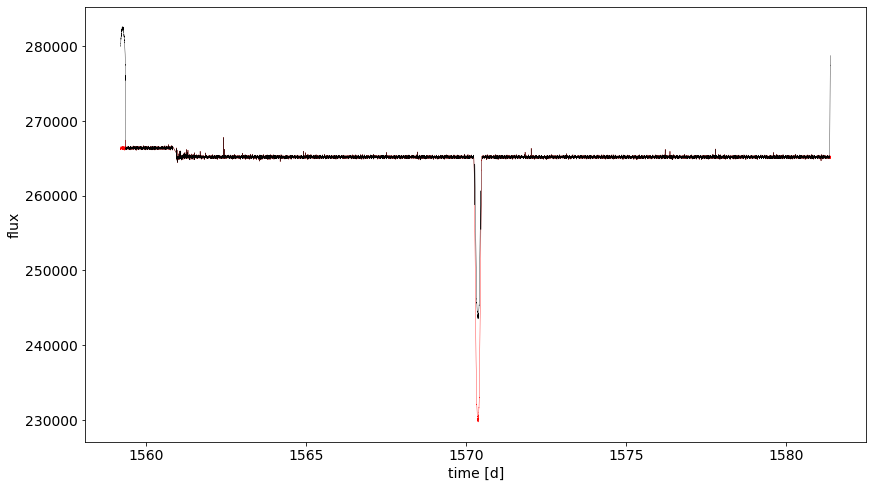

In [145]:
plt.figure(figsize=(14,8))

plt.plot(timearr, flux, c="r", linewidth=.35)
plt.plot(timearr, notransit_flux, c="k", linewidth=.35)
# plt.ylim(2.88e6,2.89e6)
plt.xlim(1141.5,1142.5)
plt.xlabel("time [d]", fontsize=14)
plt.ylabel("flux",fontsize=14)

In [146]:
ff

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,ID,qcs,mission,tstamp,dur_detrend,lc_n
0,210,240,2117951,2117981,1559.360244,1559.380678,58.608550,0.055443,0.045405,0.020434,32310.0,Kepler-16,17,Kepler,18_08_2021_13_21_31,14.812273,0
1,2386,2399,2120291,2120304,1560.954098,1560.962953,1.799417,0.094124,0.004597,0.008855,32310.0,Kepler-16,17,Kepler,18_08_2021_13_21_31,14.812273,0


In [ ]:
0.438 /2 * 24

In [ ]:
df.fold(system.pl_orbper.iloc[0]).plot();

In [ ]:
system.pl_orbper, results.period

# Backlog

In [ ]:
#work through a subset first
# row = fla.iloc[158]
phases = []
trandurs = []
for label, row in fla.iterrows():

    # TIC is unique ID for star
    system_tess = exotess[(exotess.TIC == row.ID)]

    # ID is unique, also ignore entries that have no transits
    # because there is nothing to mask (they are still searched for flares)
    system_kepler = exokepler[(exokepler.hostname == row.ID) &
                       (exokepler.discoverymethod == "Transit")]

    try:
        if system_kepler.shape[0] > 0:
            system_kepler["pl_tranmidepoch"] = (system_kepler.pl_tranmid -
                                                offset[system_kepler.iloc[0].disc_facility])

        system = pd.concat([system_kepler, system_tess],ignore_index=True)
        system = system.sort_values(by="pl_orbper",ascending=True).iloc[0]

        tmid = system.pl_tranmidepoch
        orbper = system.pl_orbper
        tflare = row.tstart
        phase = ((tflare - tmid) % orbper) / orbper
        trandurs.append(system.pl_trandur / 24. / orbper)
        phases.append(phase)
        print(phase)
    except KeyError:
        phases.append(np.nan)
        trandurs.append(0.)
        print("nope")
    except IndexError:
        phases.append(np.nan)
        trandurs.append(0.)
        print("nope")

In [ ]:
st = startrandurs[~np.isnan(startrandurs)]
np.percentile(np.sort(st),90)

In [ ]:
plt.figure(figsize=(8,5))

hist = plt.hist(phases, bins=np.linspace(0,1,10), histtype="step",edgecolor="r")
plt.axvline(np.nanmean(startrandurs), c="k", label="mean transit duration")
plt.axvline(np.percentile(np.sort(st),95), c="grey", label="95th percentile transit duration")
plt.axvline(np.nanmax(startrandurs), c="silver", label="")
plt.axhline(np.mean(hist[0]),c="orange",label="mean")
plt.fill_between(hist[1],np.mean(hist[0]) - np.std(hist[0]),
                 np.mean(hist[0]) + np.std(hist[0]),alpha=.4,
                 label="standard deviation")
# plt.axhline(np.mean(hist[0]) - np.std(hist[0]))
plt.xlim(0,1)
plt.legend(frameon=False);

In [ ]:
np.std(hist[0])

In [ ]:
fla["phase"] = phases
fla["frac_tran"] = trandurs

In [ ]:
startrandurs = fla.drop_duplicates(subset=["ID"]).frac_tran

In [ ]:
plt.hist(startrandurs, bins=np.logspace(-3,-.5,15), histtype="step", edgecolor="k")
plt.xscale("log")
plt.xlabel("duration of transit / orbital period")
plt.title(f"{len(startrandurs)} star-planet-systems with flares")

In [ ]:
np.sum(startrandurs)/len(startrandurs)

- tranmidepoch is phase 0

- select innermost component in multiplanet systems
- calculate pseudotransit mid epoch for RV planets


- the correct metric is number of flares per observed phase

In [ ]:
0.009200275324758905 * 3000

In [ ]:
system.columns

In [ ]:
import pandas as pd